# Кластеризация ЕГЭ (8.5 если сделаны все задачи)

Рядом лежат экселевские таблицы с координатами точек. В 3 и 4 задаче используется манхетеское расстояние. В остальных Евклидово.

* Постройте Распределение точек
* Кластеризуйте руками
* Постройте Распределение точек, отметьте принадлежность кластеров цветами
* Найдите среди в каждом кластере точку расстояние от которой до всех остальных минимально
* Выведите усреднение центров всех кластеров * 1000

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Кластеризация (0.75 за каждый алгоритм на всех данных)

На предложенных распределениях данных проверьте предложенные алгоритмы. Постройте графики кластеризации для каждой пары алгоритм-данные, разные кластеры покрасьте разным цветом. Воспользуйтесь sklearn реализациями. Параметры кластеризации для разных алгоритмов подберите такие, чтобы алгоритмы можно было сравнивать (по возможности одинаковое количество кластеров и т.д.)

In [68]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from itertools import cycle, islice


Dataset 0
Cluster 0
Medoid: [-0.96237777  1.25283073]
Cluster 1
Medoid: [ 0.82110773 -0.89928032]
Cluster 2
Medoid: [-0.79165176  0.44396744]
Average centers * 1000: [-290.23911364  273.51538736]

Dataset 1
Cluster 0
Medoid: [-1.09128814  0.93308954]
Cluster 1
Medoid: [1.166348   0.26869586]
Cluster 2
Medoid: [-0.09349962 -1.2117287 ]
Average centers * 1000: [6.52256027e-13 1.33226763e-12]

Dataset 2
Cluster 0
Medoid: [ 0.97843909 -0.48036947]
Cluster 1
Medoid: [ 0.83931506 -1.21410073]
Cluster 2
Medoid: [-0.96223712  0.86573365]
Average centers * 1000: [ 254.25477917 -254.58493503]

Dataset 3
Cluster 0
Medoid: [1.19075887 0.0504503 ]
Cluster 1
Medoid: [-1.1720697  -1.14018981]
Cluster 2
Medoid: [0.03713979 1.15383562]
Average centers * 1000: [16.86729967 16.64896973]

Dataset 4
Cluster 0
Medoid: [-1.21751668  0.83110634]
Cluster 1
Medoid: [ 0.82486549 -0.92566019]
Cluster 2
Medoid: [-0.5120527   1.06954673]
Average centers * 1000: [-261.68713856  307.49285541]

Dataset 5
Cluster 0
Me

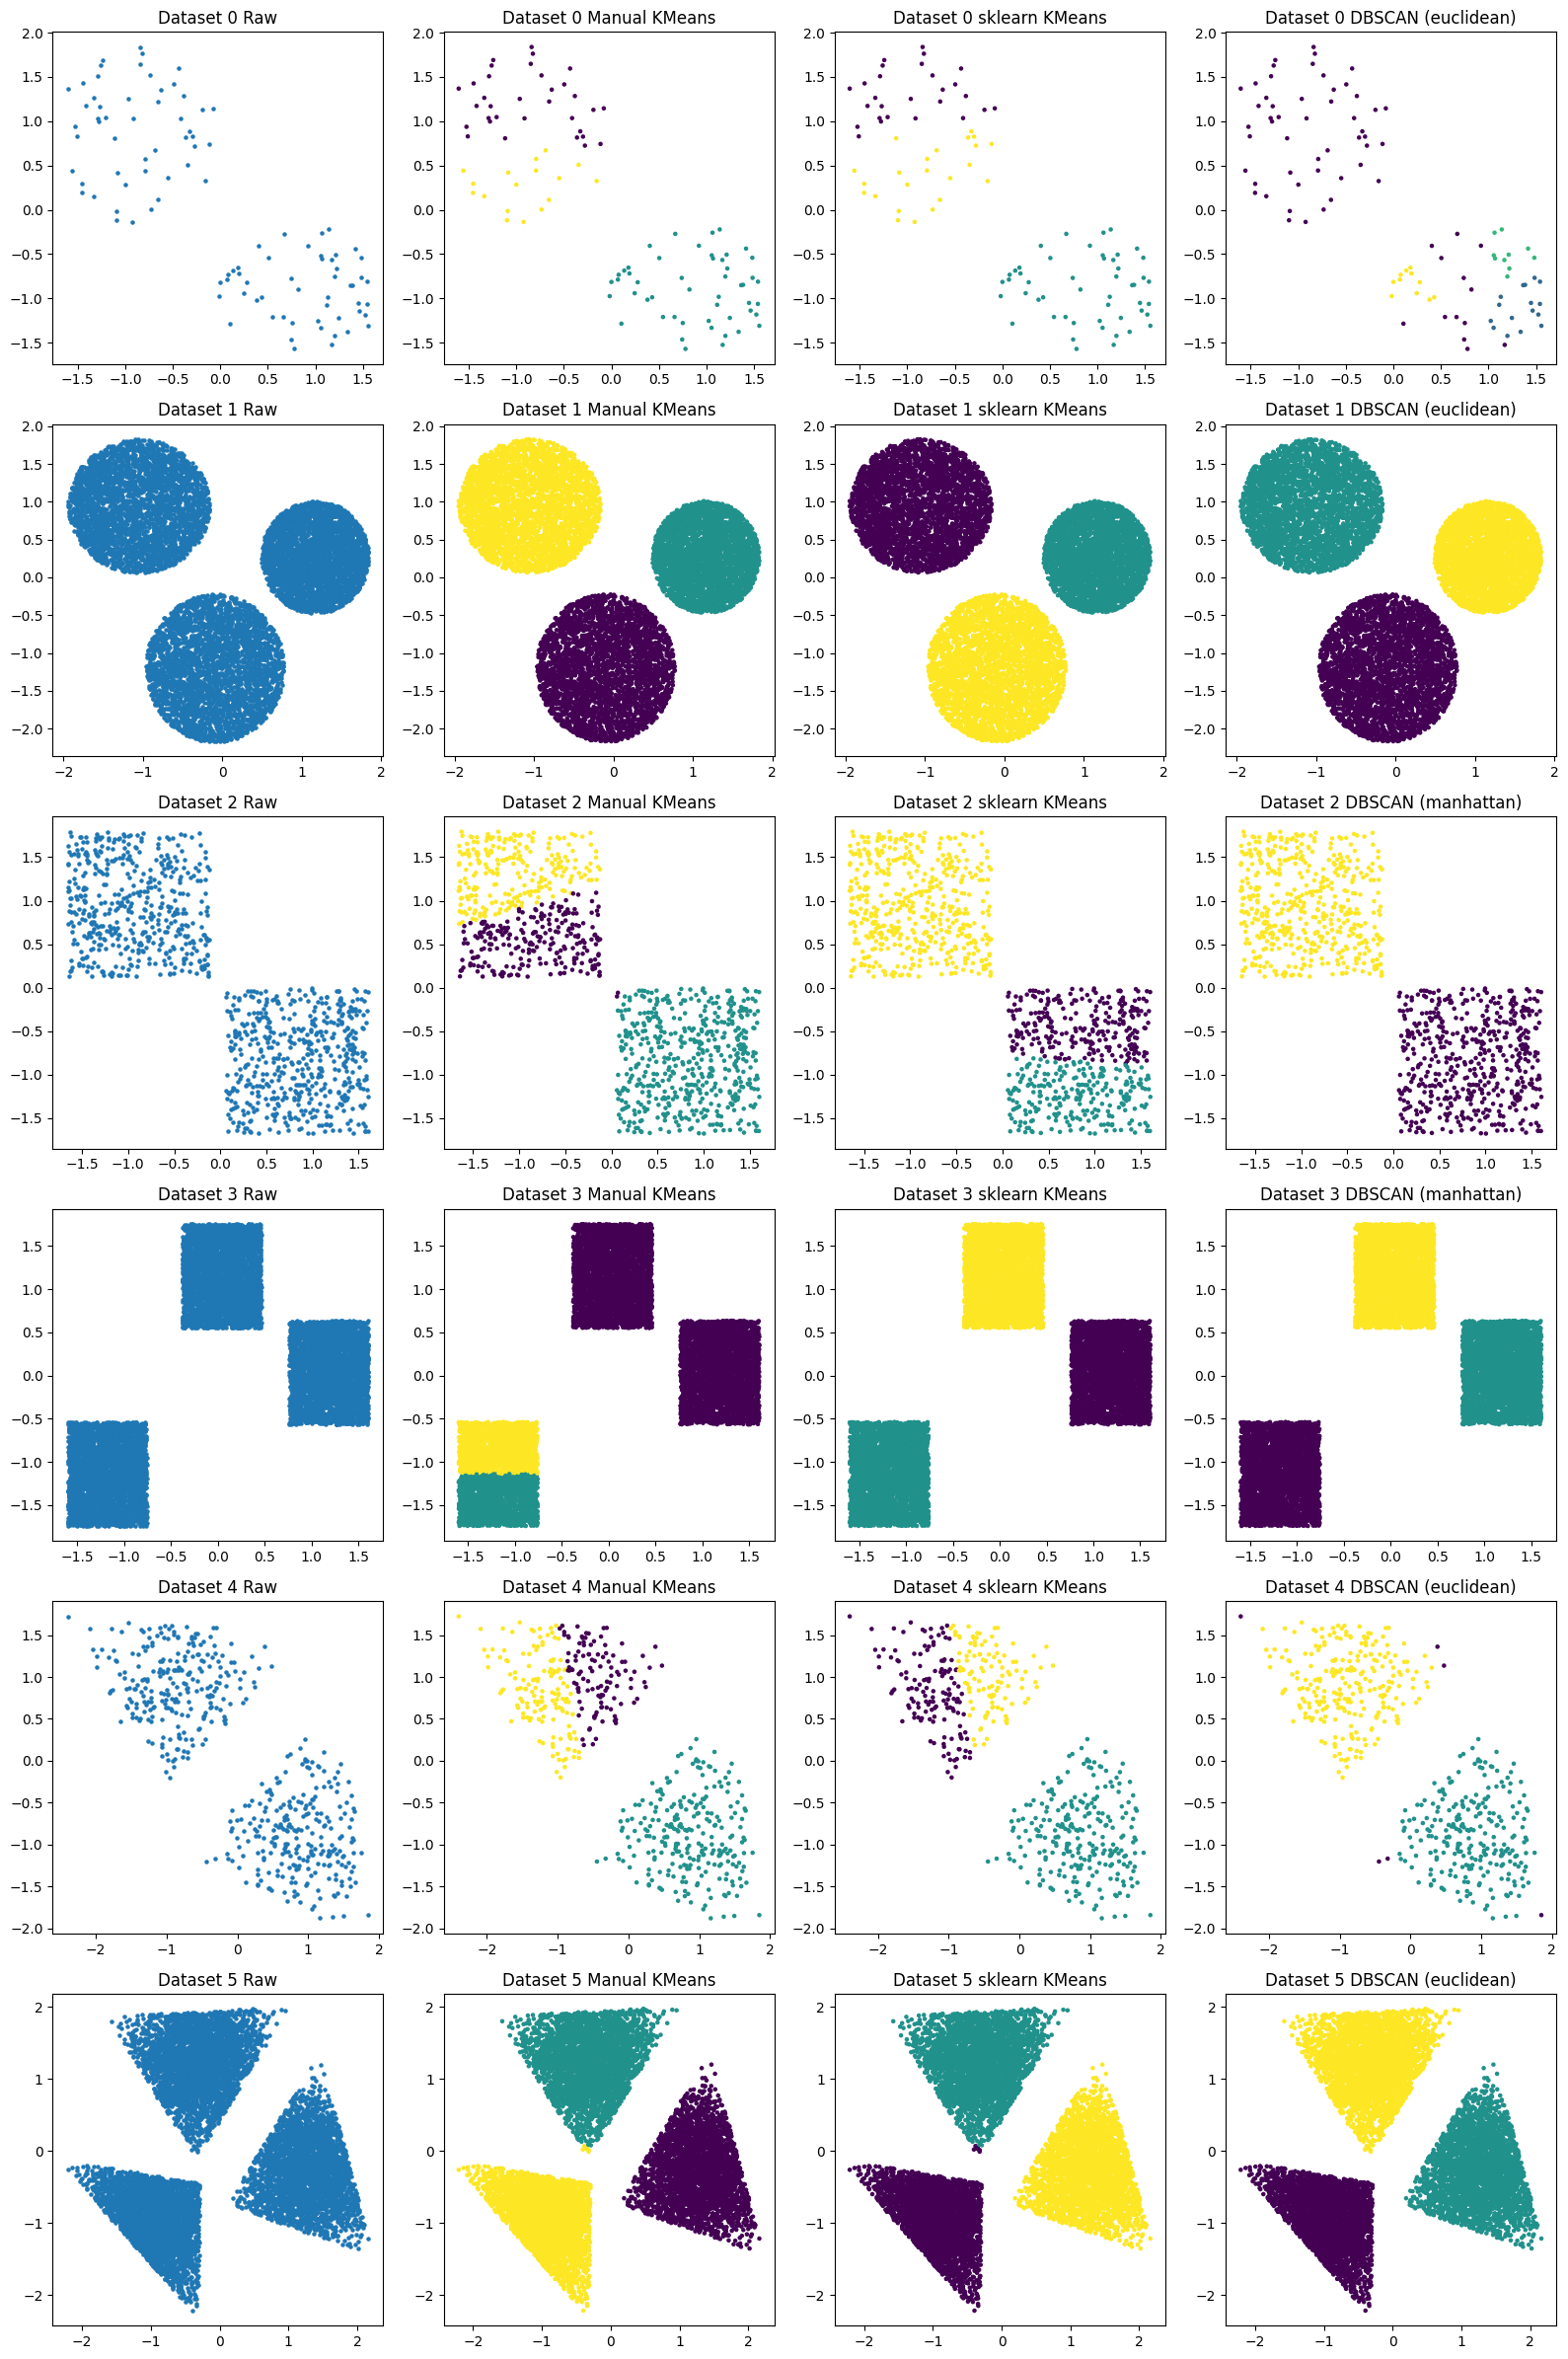

In [69]:
N_CLUSTERS = 3
FILES = [f"{i}.xlsx" for i in range(6)]

datasets = []

for filename in FILES:
    df = pd.read_excel(filename)
    X = df.iloc[:, :2].values
    datasets.append(X)

# ========================
# Ручная кластеризация
# ========================
def manual_kmeans(X, k, max_iter=100):
    rng = np.random.default_rng(42)
    centers = X[rng.choice(len(X), k, replace=False)]

    for _ in range(max_iter):
        dist = cdist(X, centers)
        labels = np.argmin(dist, axis=1)

        new_centers = np.array([
            X[labels == i].mean(axis=0) if np.any(labels == i) else centers[i]
            for i in range(k)
        ])

        if np.allclose(centers, new_centers):
            break

        centers = new_centers

    return labels, centers

def find_medoid(points, metric="euclidean"):
    scipy_metric = "cityblock" if metric == "manhattan" else metric
    dist = cdist(points, points, metric=scipy_metric)
    return points[np.argmin(dist.sum(axis=1))]

plot_num = 1
plt.figure(figsize=(16, 24))

for i, X in enumerate(datasets):
    metric = "manhattan" if i in [2, 3] else "euclidean"

    X_scaled = StandardScaler().fit_transform(X)

    plt.subplot(len(datasets), 4, plot_num)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=5)
    plt.title(f"Dataset {i} Raw")
    plot_num += 1

    labels_manual, centers_manual = manual_kmeans(X_scaled, N_CLUSTERS)

    plt.subplot(len(datasets), 4, plot_num)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_manual, s=5)
    plt.title(f"Dataset {i} Manual KMeans")
    plot_num += 1

    kmeans = cluster.KMeans(n_clusters=N_CLUSTERS, n_init=10)
    labels_kmeans = kmeans.fit_predict(X_scaled)

    plt.subplot(len(datasets), 4, plot_num)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_kmeans, s=5)
    plt.title(f"Dataset {i} sklearn KMeans")
    plot_num += 1
    
    dbscan = cluster.DBSCAN(eps=0.3, min_samples=10, metric=metric)
    labels_dbscan = dbscan.fit_predict(X_scaled)

    plt.subplot(len(datasets), 4, plot_num)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_dbscan, s=5)
    plt.title(f"Dataset {i} DBSCAN ({metric})")
    plot_num += 1

    print(f"\nDataset {i}")

    labels_used = labels_kmeans
    unique_labels = [l for l in np.unique(labels_used) if l != -1]

    centers = []

    for lbl in unique_labels:
        cluster_points = X_scaled[labels_used == lbl]

        medoid = find_medoid(cluster_points, metric)
        center = cluster_points.mean(axis=0)

        centers.append(center)

        print(f"Cluster {lbl}")
        print("Medoid:", medoid)

    if centers:
        avg_center = np.mean(centers, axis=0) * 1000
        print("Average centers * 1000:", avg_center)

plt.tight_layout()
plt.show()
